# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

### First, I'll compute the camera calibration using chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Calculate callibration img size
img = mpimg.imread(images[0])
call_img_size = img.shape
print(call_img_size)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
    else:
        print('Corners not found for : {}'.format(fname))

cv2.destroyAllWindows()

(720, 1280, 3)
Corners not found for : camera_cal/calibration1.jpg
Corners not found for : camera_cal/calibration4.jpg
Corners not found for : camera_cal/calibration5.jpg


### Undistort Images

In [3]:
def undistort_img(img):
    print(img.shape)
    assert (img.shape == call_img_size),'image size is not compatible with callibration camera images'
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

(720, 1280, 3)


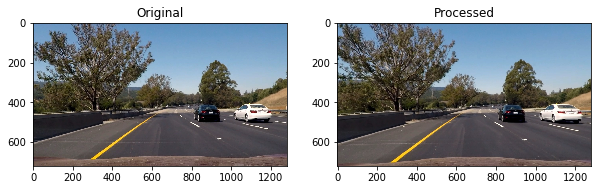

In [4]:
# TEST

org = mpimg.imread('test_images/test6.jpg')
und = undistort_img(org)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.set_title('Original')
ax1.imshow(org)
ax2.set_title('Processed')  
ax2.imshow(und)

### Defining various Gradients  : sobel, magnitude, direction

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

### Combining the thresholds of gradients

In [6]:
def combined_thresh(image, ksize = 3):
    # Choose a Sobel kernel size

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 110))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 110))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(20, 100))
    dir_binary = dir_thresh(image, sobel_kernel=ksize, thresh=(0.8,1.2)) 
    combined = np.zeros_like(dir_binary, np.uint8)    
    combined[((gradx == 1) | (gradx == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1
    return combined

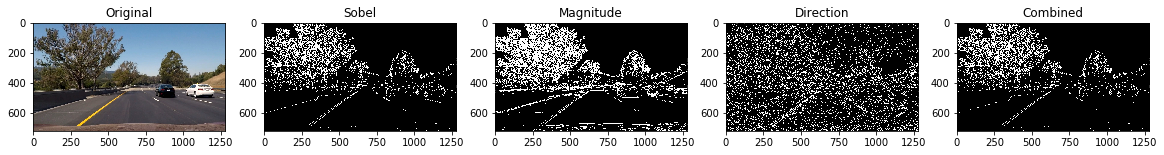

In [15]:
# TEST

org = mpimg.imread('test_images/test6.jpg')
sobel = abs_sobel_thresh(org, thresh=(20, 110))
mag = mag_thresh(org, thresh=(20, 100))
dire = dir_thresh(org, thresh=(0.8,1.2))
comb = combined_thresh(org)


f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,15))
ax1.set_title('Original')
ax1.imshow(org)
ax2.set_title('Sobel')  
ax2.imshow(sobel, cmap = 'gray')
ax3.set_title('Magnitude')  
ax3.imshow(mag, cmap = 'gray')
ax4.set_title('Direction')  
ax4.imshow(dire, cmap = 'gray')
ax5.set_title('Combined')  
ax5.imshow(comb, cmap = 'gray')

### Color filters and thresholding

In [16]:
def color_thresh(image):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # Threshold color channel
    s_thresh_min = 80
    s_thresh_max = 255
    l_thresh_min = 190
    l_thresh_max = 255  
    
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)) ] = 1
    
    l_binary = np.zeros_like(s_channel)
    l_binary[((l_channel >= l_thresh_min) & (l_channel <= l_thresh_max))] = 1
    
    return s_binary, l_binary

### Color and Gradient thresholding combined

In [17]:
def combine_color_gradients(image):

    sxbinary = combined_thresh(image)
    s_binary, l_binary = color_thresh(image)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) | ((sxbinary == 1) & (l_binary == 1))] = 1
    
    return combined_binary

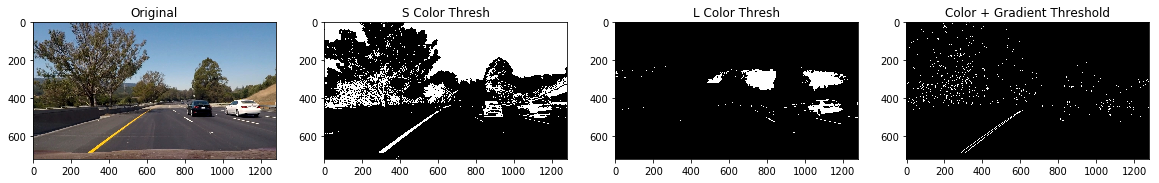

In [25]:
# TEST

org = mpimg.imread('test_images/test6.jpg')
s_color, l_color = color_thresh(org)
combined = combine_color_gradients(org)


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,15))
ax1.set_title('Original')
ax1.imshow(org)
ax2.set_title('S Color Thresh')  
ax2.imshow(s_color, cmap = 'gray')
ax3.set_title('L Color Thresh')  
ax3.imshow(l_color, cmap = 'gray')
ax4.set_title('Color + Gradient Threshold')  
ax4.imshow(combined, cmap = 'gray')